In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
display.set_matplotlib_formats('svg')
from torch.utils.data import DataLoader, TensorDataset

/var/folders/nn/4_714bpd2qz7gm9d27_r3qw40000gn/T/ipykernel_22545/2876529873.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [44]:
import seaborn as sns
iris = sns.load_dataset('iris')

In [19]:
from sklearn.model_selection import train_test_split

In [45]:
# organize the data

# convert pandas dataframe into pytorch tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to numbers

labels = torch.zeros(len(data), dtype = torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

labels.shape

torch.Size([150])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# finally, translate into dataloader objects
train_loader = DataLoader(train_data,shuffle=True,batch_size=12)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [52]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

X,y

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


(tensor([[6.5000, 3.0000, 5.5000, 1.8000],
         [5.0000, 3.6000, 1.4000, 0.2000],
         [5.7000, 2.5000, 5.0000, 2.0000],
         [7.7000, 2.8000, 6.7000, 2.0000],
         [4.9000, 2.5000, 4.5000, 1.7000],
         [5.5000, 2.5000, 4.0000, 1.3000],
         [5.6000, 3.0000, 4.5000, 1.5000],
         [5.9000, 3.0000, 4.2000, 1.5000],
         [5.4000, 3.9000, 1.3000, 0.4000],
         [7.2000, 3.2000, 6.0000, 1.8000],
         [5.4000, 3.9000, 1.7000, 0.4000],
         [6.4000, 2.9000, 4.3000, 1.3000]]),
 tensor([2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 0, 1]))

In [48]:
class ANNiris(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()
        
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers
        
        #input layer
        self.layers['input'] = nn.Linear(4, nUnits)
        
        # hidden layer
        for i in range(nLayers):
            self.layers[f'hidden {i}'] = nn.Linear(nUnits, nUnits)
        
        # output layer
        self.layers['output'] = nn.Linear(nUnits, 3)
        
    def forward(self, x):
        x = self.layers['input'](x)
        
        for i in range(self.nLayers):
            x = F.relu(self.layers[f'hidden {i}'](x))
        
        x = self.layers['output'](x)
        
        return x

In [49]:
numepochs = 500
def trainModel(model):
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    
    trainAcc = []
    testAcc = []
    
    for epochi in range(numepochs):
        batchScore = []
        for x, y in train_loader:
            yHat = model(x)
            
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            predLabels = torch.argmax(yHat, axis = 1)
            batchAcc = 100 * torch.mean((predLabels == y).float())
            batchScore.append(batchAcc)
        
        trainAcc.append(np.mean(batchScore))
        
        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax( model(X),axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
    return trainAcc, testAcc 

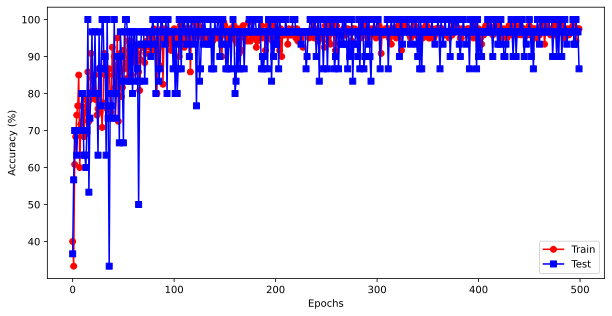

In [50]:
net = ANNiris(12, 3)
trainAcc, testAcc = trainModel(net)

fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

# optional zoom-in to final epochs
# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()